# Integrated Project I
We work for the online store Ice, which sells video games all over the world. User and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales are available from open sources. We need to identify patterns that determine whether a game succeeds or not. This will allow us to spot potential big winners and plan advertising campaigns.


## Data
Column descriptions:
- Name
- Platform
- Year_of_Release
- Genre
- NA_sales (North American sales in USD million)
- EU_sales (sales in Europe in USD million)
- JP_sales (sales in Japan in USD million)
- Other_sales (sales in other countries in USD million)
- Critic_Score (maximum of 100)
- User_Score (maximum of 10)
- Rating (ESRB)

Data for 2016 may be incomplete.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt 

In [2]:
df = pd.read_csv('/datasets/games.csv')

First we'll look at a random sample from the dataset.

In [3]:
df.sample(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
16174,50 Classic Games,3DS,2012.0,Misc,0.00,0.01,0.00,0.00,NaN,NaN,NaN
9135,Cities: Skylines,PC,2015.0,Simulation,0.00,0.13,0.00,0.01,85.0,8.9,E
5043,Naruto Shippuden: Ultimate Ninja Heroes 3,PSP,2009.0,Fighting,0.13,0.04,0.19,0.03,61.0,6.6,T
13170,Detective Conan: Prelude from the Past,DS,2012.0,Action,0.00,0.00,0.05,0.00,NaN,NaN,NaN
6010,Marvel Super Hero Squad,PS2,2009.0,Fighting,0.14,0.11,0.00,0.04,NaN,tbd,E10+
15771,Spirits & Spells,GC,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN
13468,Wolfenstein,PC,2009.0,Shooter,0.01,0.03,0.00,0.01,74.0,7.3,M
6504,NCAA March Madness 08,PS2,2007.0,Sports,0.13,0.10,0.00,0.03,NaN,5,E
13470,Nazo Waku Yakata: Oto no Ma ni Ma ni,3DS,2011.0,Misc,0.00,0.00,0.05,0.00,NaN,NaN,NaN
6626,NHL 08,PS3,2007.0,Action,0.16,0.06,0.00,0.03,86.0,6.9,E10+


Next, basic information.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


We can see some datatype mismatches and missing values. This will be taken care of in the next section.

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year_of_Release,16446.0,2006.484616,5.877050,1980.0,2003.0,2007.00,2010.00,2016.00
NA_sales,16715.0,0.263377,0.813604,0.0,0.0,0.08,0.24,41.36
EU_sales,16715.0,0.145060,0.503339,0.0,0.0,0.02,0.11,28.96
JP_sales,16715.0,0.077617,0.308853,0.0,0.0,0.00,0.04,10.22
Other_sales,16715.0,0.047342,0.186731,0.0,0.0,0.01,0.03,10.57
Critic_Score,8137.0,68.967679,13.938165,13.0,60.0,71.00,79.00,98.00


In [6]:
df.describe(include=np.object).T

,count,unique,top,freq
Name,16713,11559,Need for Speed: Most Wanted,12
Platform,16715,31,PS2,2161
Genre,16713,12,Action,3369
User_Score,10014,96,tbd,2424
Rating,9949,8,E,3990


We can already get some insights, just by looking at basic stats of the raw data: 
- Less than a quarter of the games in the dataset were released in the last 5 years
- The highest sales by any metric are in North America, followed by Europe, Japan, and lastly, 'Other'
- The mean and median critic score are very near (69 and 71, respectively), so we might expect a near normal distribution
- Need for Speed: Most Wanted appeared in no less than 12(!) platforms, more than any other game
- The Playstation 2 is the platform with the most titles (2161 titles)
- The most common genre is action (3369 titles)
- The most common ESRB rating is E (everyone) (3990 titles)

## Preprocessing

First, we can convert column titles to lowercase to make things easier.

In [7]:
df.columns = df.columns.str.lower()

The user scores are numbers stored as strings. We'll convert them to numbers, and values like `'tbd'` will be stored as `NaN`.

In [8]:
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

Let's check how many `NaN` values we have.

In [9]:
for column in ['name', 'year_of_release', 'critic_score', 'user_score', 'rating']:
    print('NaN values in {}: {} ({:.1%})\n'.format(
        column,
        sum(df[column].isna()),
        sum(df[column].isna()) / len(df)
    ))

NaN values in name: 2 (0.0%)

NaN values in year_of_release: 269 (1.6%)

NaN values in critic_score: 8578 (51.3%)

NaN values in user_score: 9125 (54.6%)

NaN values in rating: 6766 (40.5%)



The number of games for which the name or year of release is unknown is negligible, and the rest of the data is not very useful without knowing the year. On the other hand, too many critic and user scores and ratings are missing to just drop them, so we will keep them as `NaN`.

In [10]:
df.dropna(subset=['name', 'year_of_release'], inplace=True)

There's no reason to store years as `float`.

In [11]:
df['year_of_release'] = df['year_of_release'].astype('int16')

The critic scores go from 0 to 100, while user scores go from 0 to 10. We want scores from critics and users to be on the same scale, so we'll divide the critic scores by 10.

In [12]:
df['critic_score'] = df['critic_score'] * 0.1

Next, we'll check out the ratings.

In [13]:
df['rating'].value_counts()

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
RP         1
AO         1
Name: rating, dtype: int64

We can tidy this up a little. `'K-A'` (kids to adults) is the predecessor of `'E'` (everyone), and `'EC'` (early childhood) was rarely used because `'E'` is inclusive of this group. `'RP'` (rating pending) is a sort of a placeholder for games yet to be rated, so we might as well convert all `NaN` (which we have in abundance) to `'RP'`. There is one single `'AO'` (adult only) game in our dataset. Let's find out what we can about it before deciding what to do with it.

In [14]:
df.query('rating == "AO"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
875,Grand Theft Auto: San Andreas,XB,2005,Action,1.26,0.61,0.0,0.09,9.3,8.6,AO


This is a major hit, so we can't just drop it from the dataset. From a little online research we know that the final rating for this title was `'M'` (mature). By applying all of the above, we can pidgeonhole all ratings into 5 values. While we're at it, let's add a numeric `'rating_id'` column, in which 1-4 correspond to ratings in ascending appropriate player age, and 0 indicates yet to be rated games.

In [15]:
df['rating'].fillna('RP', inplace=True)
df.loc[df['rating'].isin(['K-A', 'EC']), 'rating'] = 'E'
df.loc[df['rating'] == 'AO', 'rating'] = 'M'

In [16]:
esrb_dict = pd.DataFrame({'rating': ['RP', 'E', 'E10+', 'T', 'M'], 'rating_id': list(range(5))})
df = df.merge(esrb_dict, on='rating')
df['rating_id'] = df['rating_id'].astype('int8')

To save space, we'll downsize all of the `float64` data types in the dataset to `float32`. We don't want to use the even lighter `float16` because it's incompatible with some pandas functions.

In [17]:
for column in ['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score']:
    df[column] = df[column].astype('float32')

Let's add another column for total combined sales of all 4 regions we have data for.

In [18]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,rating_id,total_sales
0,Wii Sports,Wii,2006,Sports,41.360001,28.959999,3.77,8.45,7.6,8.0,E,1,82.539993
1,Mario Kart Wii,Wii,2008,Racing,15.680000,12.760000,3.79,3.29,8.2,8.3,E,1,35.520000
2,Wii Sports Resort,Wii,2009,Sports,15.610000,10.930000,3.28,2.95,8.0,8.0,E,1,32.770000
3,New Super Mario Bros.,DS,2006,Platform,11.280000,9.140000,6.50,2.88,8.9,8.5,E,1,29.799999
4,Wii Play,Wii,2006,Misc,13.960000,9.180000,2.93,2.84,5.8,6.6,E,1,28.910000


Finally, we'll have a look at the data info after preprocessing.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16443
Data columns (total 13 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int16
genre              16444 non-null object
na_sales           16444 non-null float32
eu_sales           16444 non-null float32
jp_sales           16444 non-null float32
other_sales        16444 non-null float32
critic_score       7983 non-null float32
user_score         7463 non-null float32
rating             16444 non-null object
rating_id          16444 non-null int8
total_sales        16444 non-null float32
dtypes: float32(7), int16(1), int8(1), object(4)
memory usage: 1.1+ MB


The dataset have shed about 20% of its weight, despite adding two new columns and filling in thousands of missing values in `'rating'`.

## General Analysis

### By Year
We start by plotting how many games were relesed each year.

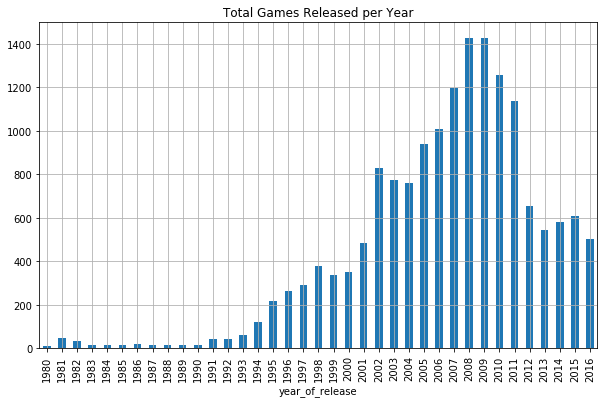

In [20]:
# pandas version
df.pivot_table(
    index='year_of_release', 
    aggfunc='count', 
    values='name',
).plot(
    kind='bar', 
    figsize=(10, 6), 
    grid=True, 
    legend=False, 
    title='Total Games Released per Year',
)

plt.show()

We can see that the number of games released year by year mostly increased since the early 90's, until hitting a peak in 2008-2009, when over 1400 games were released in both years. After that the pace went down, and has been within the 500-700 games per year range in the last 5 years. 
### Life Cycle of a Platform 
Next, we want to figure out on which platforms games turned the most profit.

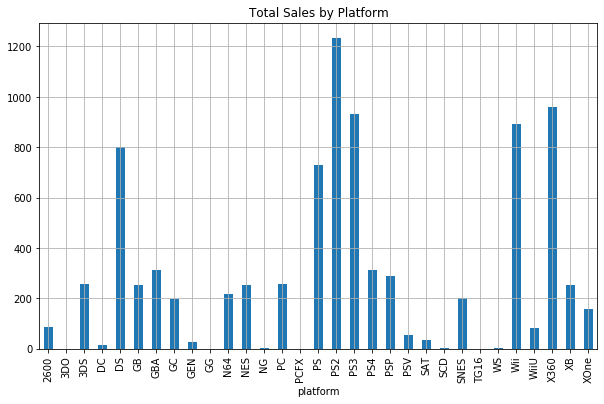

In [21]:
df.pivot_table(
    index='platform', 
    aggfunc='sum', 
    values='total_sales',
).plot(
    kind='bar', 
    figsize=(10, 6), 
    grid=True, 
    legend=False, 
    title='Total Sales by Platform',
)

plt.show()

We'll take a look on how the 5 top platforms performed over the years: Sony Playstation 2, Xbox 360, Sony Playstation 3, Nintendo Wii and Nintendo DS.

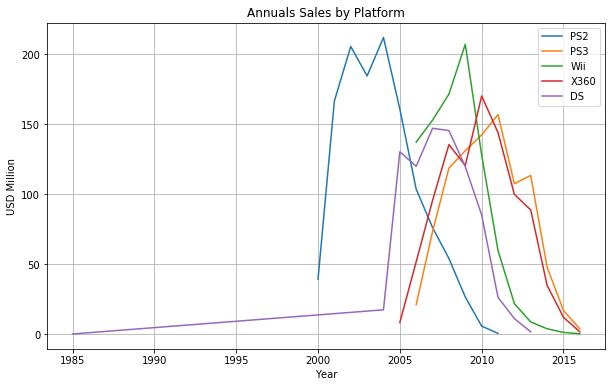

In [22]:
plt.figure(figsize=(10, 6))

for platform in ['PS2', 'PS3', 'Wii', 'X360', 'DS']:
    pivot = df.query('platform == @platform').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
    plt.plot(pivot, label=platform)

plt.title('Annuals Sales by Platform')
plt.xlabel('Year')
plt.ylabel('USD Million')
plt.grid()
plt.legend()
plt.show()

Did games for the DS go on sale two decades before the platform was released? Probably not. Some rogue entry is distorting the DS data. Let's get rid of it.

In [23]:
df.query('platform == "DS" and year_of_release < 2004')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,rating_id,total_sales
10125,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,NaN,NaN,RP,0,0.02


In [24]:
df.drop(10125, inplace=True)

Now the graph should be right.

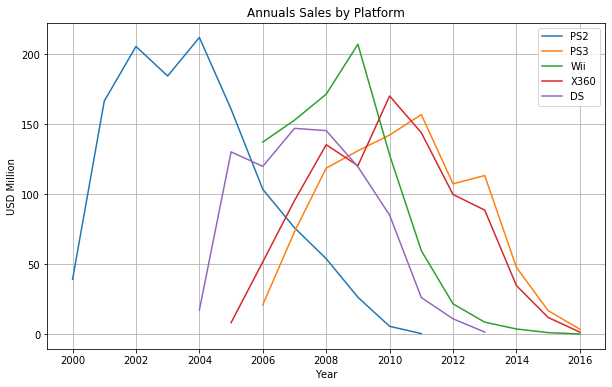

In [25]:
plt.figure(figsize=(10, 6))

for platform in ['PS2', 'PS3', 'Wii', 'X360', 'DS']:
    pivot = df.query('platform == @platform').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
    plt.plot(pivot, label=platform)

plt.title('Annuals Sales by Platform')
plt.xlabel('Year')
plt.ylabel('USD Million')
plt.grid()
plt.legend()
plt.show()

There seems to be a pattern. Sales rise for a few years, hit a peak or two, and decline. It makes perfect sense, as new platform get released every several years, and newer games are developed for newer, stronger hardwere. 
### Current Platforms
We are interested in which platform is expected to do well in 2017, but all of the all time top 5 are already obsolete. Let's check which newer platforms did well in the last 3 years only.

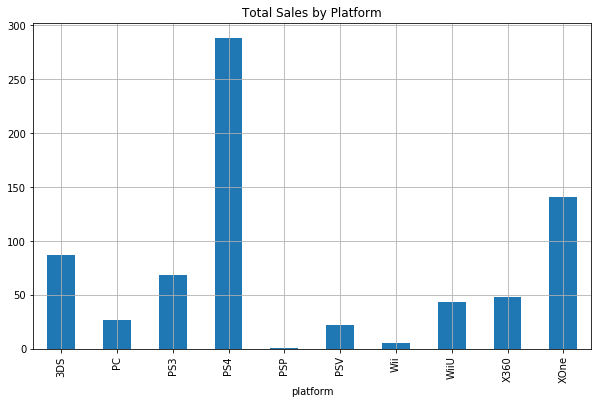

In [26]:
df.query('year_of_release > 2013').pivot_table(
    index='platform', 
    aggfunc='sum', 
    values='total_sales',
).plot(
    kind='bar', 
    figsize=(10, 6), 
    grid=True, 
    legend=False, 
    title='Total Sales by Platform',
)

plt.show()

This time, we'll take a closer look at Sony Playstation 4, Xbox One and Nintendo 3DS.

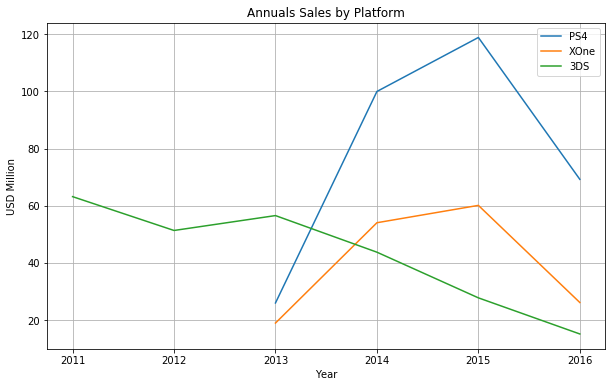

In [27]:
plt.figure(figsize=(10, 6))

for platform in ['PS4', 'XOne', '3DS']:
    pivot = df.query('platform == @platform').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
    plt.plot(pivot, label=platform)

plt.title('Annuals Sales by Platform')
plt.xlabel('Year')
plt.ylabel('USD Million')
plt.grid()
plt.legend()
plt.show()

We shouldn't be worried about the dip in 2016, as data for the current year is incomplete, and likely excludes the highly profitable holiday season. With that in mind, the platforms entering 2017 with an upward trajectory are the Playstation 4 and Xbox One, with the former doing significantly better than the latter. 

Next, we'll compare the game sales distributions of various platforms in 2014 to 2016.

In [28]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

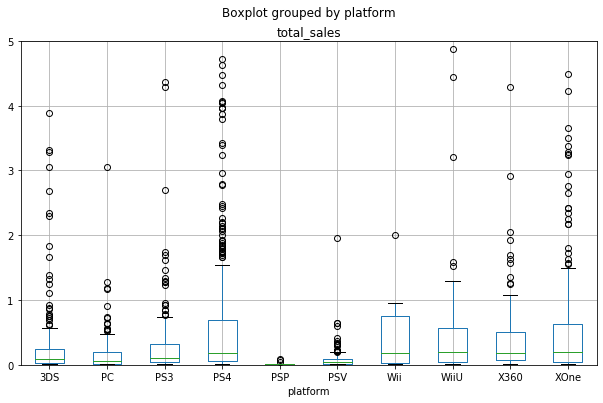

In [29]:
df.query('year_of_release > 2013').boxplot(
    'total_sales', 
    by='platform', 
    figsize=(10, 6),
)
plt.ylim(0, 5)
plt.show()

In [30]:
df.query('year_of_release > 2013').pivot_table(
    values='total_sales', 
    index='platform', 
    aggfunc=['count', 'mean', 'std', 'median', 'sum'],
).sort_values(('sum', 'total_sales'), ascending=False)

,count,mean,std,median,sum
,total_sales,total_sales,total_sales,total_sales,total_sales
platform,,,,,
PS4,376,0.766356,1.614969,0.185,288.149994
XOne,228,0.615614,1.046513,0.205,140.360001
3DS,212,0.408868,1.188368,0.090,86.680000
PS3,219,0.311324,0.633059,0.110,68.180000
X360,111,0.434414,0.628967,0.180,48.220001
WiiU,73,0.588767,1.161467,0.190,42.980000
PC,151,0.179139,0.329359,0.060,27.050001
PSV,295,0.075932,0.141591,0.040,22.400000


What all platforms have in common, is that the sales distributions have a strong positive skew. It means that most profit comes from a relatively small selection of very successful games. The Playstation 4 is the platform on which the average game is most profitable, at 766K USD, followed by Xbox One and WiiU, both roughly 600K USD. Playstation 4 is also the platform with most games published since 2014, 376 titles, compared to only 228 and 212 for the Xbox One and Nintendo 3DS, respectively. 

From what we have seen until now, Sony Playstation 4 seems like the preferable platform to publish a game for (in reality it's possible to publish on multiple platforms, and it is often done). Now we'll check for correlation between profitability and user or critic scores in games for the Playstation 4.

In [31]:
psiv = df.query('platform == "PS4"').copy()

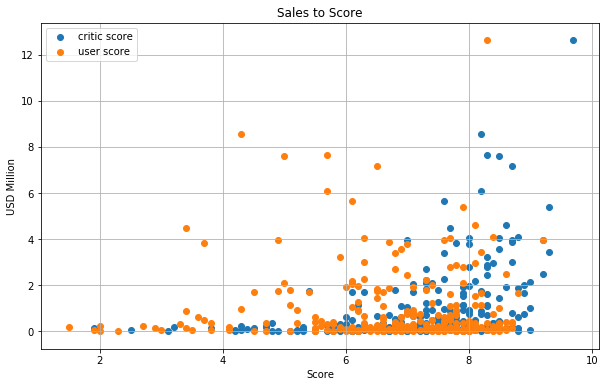

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(psiv['critic_score'], psiv['total_sales'], label='critic score')
plt.scatter(psiv['user_score'], psiv['total_sales'], label='user score')
plt.title('Sales to Score')
plt.xlabel('Score')
plt.ylabel('USD Million')
plt.grid()
plt.legend()
plt.show()

In [33]:
print('Correlation to sales\n' + '=' * 20)
print(f'Critic score: {psiv["critic_score"].corr(psiv["total_sales"]):.2f}')
print(f'User score: {psiv["user_score"].corr(psiv["total_sales"]):.2f}')

Correlation to sales
Critic score: 0.41
User score: -0.03


While user scores are virtually independant of sales performance, critic scores are moderately correlated to sales. It doesn't mean games succeed or fail based on what critics think of them. We have to remember that correlation is not causation. It is more likely that the same games that get high scores are also more profitable simply because they are more enjoyable to both critics and consumers (but apparently not the ones that bother to give scores).

Next, we will see how the same games performed on the Playstation 4 compared to the Xbox One. We'll exclude games that profited under USD 2 million combined, so that the graph doesn't get too packed.

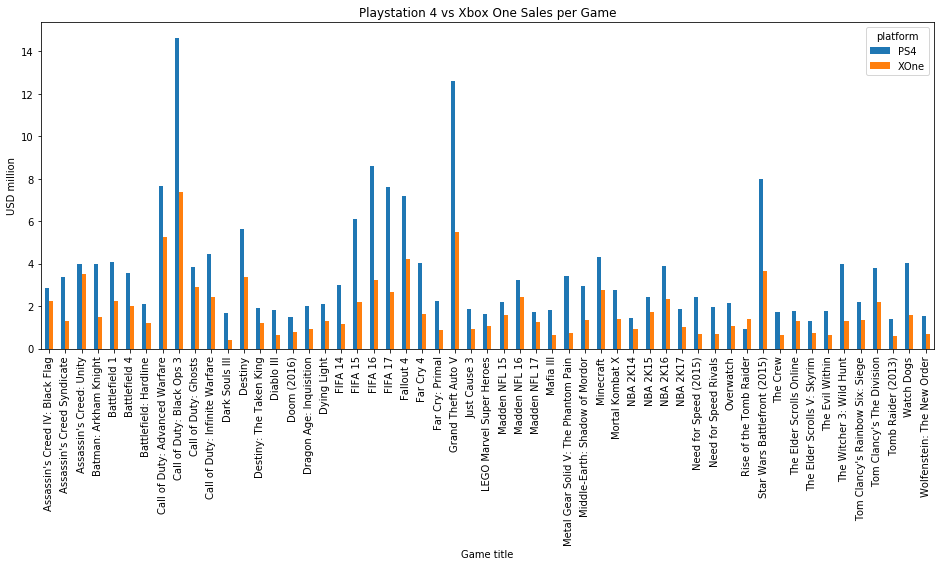

In [34]:
df.query('platform in ["PS4", "XOne"]').pivot_table(
    index='name',
    columns='platform',
    values='total_sales',
).dropna(
).query(
    'PS4 + XOne > 2',
).plot(
    kind='bar', 
    figsize=(16, 6), 
    title='Playstation 4 vs Xbox One Sales per Game',
)
plt.ylabel('USD million')
plt.xlabel('Game title')
plt.show()

Games cosistantly performed better on the Playstation 4, in several instances cashing in more than twice as they did on the Xbox One. The only exception in our dataset is the 2015 Square Enix's "Rise of the Tomb Raider".
### By Genre
So far we considered the platform, but what about the genre? Let's compare the sales distributions of different genres over the last 3 years.

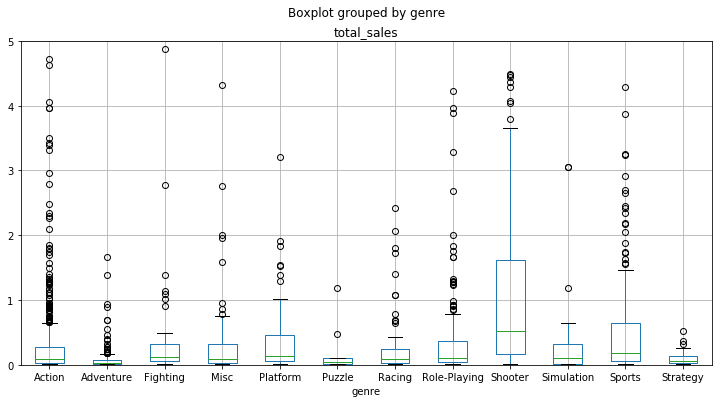

In [35]:
df.query('year_of_release > 2013').boxplot(
    'total_sales', 
    by='genre', 
    figsize=(12, 6),
)
plt.ylim(0, 5)
plt.show()

In [36]:
df.query('year_of_release > 2013').pivot_table(
    values='total_sales', 
    index='genre', 
    aggfunc=['count', 'mean', 'std', 'median', 'sum'],
).sort_values(('mean', 'total_sales'), ascending=False)

,count,mean,std,median,sum
,total_sales,total_sales,total_sales,total_sales,total_sales
genre,,,,,
Shooter,128,1.335469,2.050567,0.515,170.940002
Sports,161,0.680000,1.239736,0.180,109.480003
Platform,38,0.476053,0.722561,0.140,18.090000
Fighting,60,0.470333,1.188053,0.125,28.219999
Role-Playing,221,0.459005,1.177284,0.110,101.440002
Racing,69,0.398841,0.963716,0.090,27.520000
Misc,113,0.332301,0.736999,0.090,37.549999
Action,619,0.322068,0.798181,0.090,199.360001


Shooter have been the most profitable genre over the last 3 year, by a large margin, with USD 1.3 million per game on average. The second highest was sports, with USD 680K. The other genres had less than USD 500K total sales each, with puzzle, strategy and adventure doing particularily bad, cashing in USD 158K, 107K and 95K, respectively. 
Action games made the most money in total despite the mediocre per game average, by virtue of being the most common genre.

## Analysis by Region

In this section we will look at seperate data for each region: North America, Europe and Japan. We will explore sales by console, genre and rating. Like in the previous section, we only consider games published from 2014 onward.

In [37]:
def regional(sales, index):
    df_new = df.query('year_of_release > 2013').pivot_table(
        index=index, 
        values=sales, 
        aggfunc='sum',
    ).sort_values(
        sales, 
        ascending=False,
    )
    df_new['%'] = df_new[sales] / df_new[sales].sum() * 100
    return df_new

In [38]:
def reg_rating(sales):
    rating = regional(sales, 'rating_id').sort_index()
    rating.index = esrb_dict['rating']
#     rating.drop('RP', inplace=True)
#     rating['%'] = rating[sales] / rating[sales].sum() * 100

    return rating

In [39]:
def sales_barplot(series, title):
    series.plot(
        kind='bar', 
        title=title, 
        legend=False, 
        figsize=(8, 5)
    )
    plt.ylabel('USD million')
    plt.show()

### North America

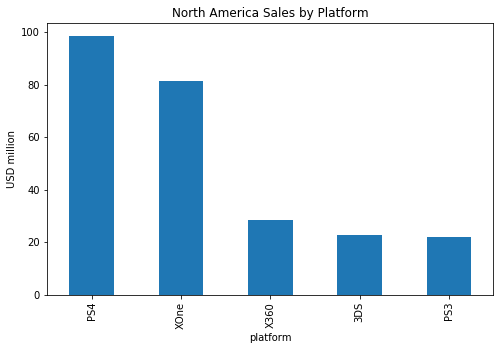

,na_sales,%
platform,,
PS4,98.610001,34.714497
XOne,81.269997,28.610151
X360,28.299999,9.962684
3DS,22.639999,7.970147
PS3,22.049999,7.762444
WiiU,19.360001,6.815462
PC,7.230000,2.545237
PSV,2.520000,0.887137
Wii,2.080000,0.732240


In [40]:
sales_barplot(regional('na_sales', 'platform')['na_sales'].head(), 'North America Sales by Platform')
regional('na_sales', 'platform')

In North America, Playstation 4 games occupy the largest market share (34.7%), but the Xbox One is not far behind (28.6%). Other platforms take up less than 10% each.

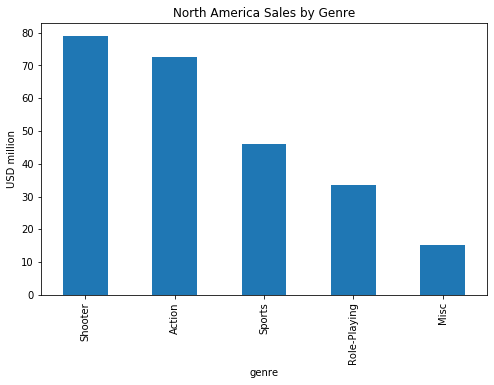

,na_sales,%
genre,,
Shooter,79.019997,27.818064
Action,72.529999,25.533337
Sports,46.130001,16.239525
Role-Playing,33.470001,11.782722
Misc,15.050000,5.298176
Fighting,12.430000,4.375836
Racing,8.740000,3.076814
Platform,6.790000,2.390340
Adventure,5.640000,1.985496


In [41]:
sales_barplot(regional('na_sales', 'genre')['na_sales'].head(), 'North America Sales by Genre')
regional('na_sales', 'genre')

In North America, the most profitable genres are shooter and action, holding slightly over a quarter of the market each. Next are sports (16%) and RPG (12%). 

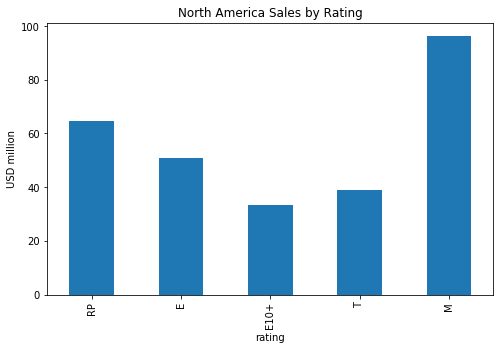

,na_sales,%
rating,,
RP,64.720001,22.783920
E,50.740002,17.862425
E10+,33.230000,11.698233
T,38.950001,13.711892
M,96.419998,33.943535


In [42]:
sales_barplot(reg_rating('na_sales')['na_sales'], 'North America Sales by Rating')
reg_rating('na_sales')

The North American audience is not deterred by ESRB's M (mature) rating. Slightly over a third of sales are attributed to games with this rating. In this market, there's no need to hold back with violence etc.

### Europe

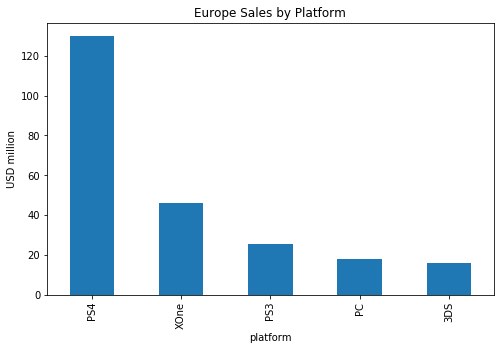

,eu_sales,%
platform,,
PS4,130.039993,48.041965
XOne,46.250000,17.086597
PS3,25.539999,9.435495
PC,17.969999,6.638835
3DS,16.120001,5.955372
X360,15.490000,5.722624
WiiU,13.150000,4.858135
PSV,3.530000,1.304123
Wii,2.590000,0.956849


In [43]:
sales_barplot(regional('eu_sales', 'platform')['eu_sales'].head(), 'Europe Sales by Platform')
regional('eu_sales', 'platform')

In Europe games for the Playstation 4 win by knockout, taking up almost half of the market. The Xbox One does come second, but only has a 17% market share. Like in North America, other platforms occupy less than 10% of the market each. 

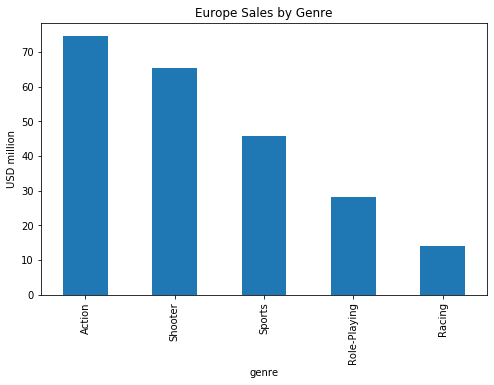

,eu_sales,%
genre,,
Action,74.680000,27.589775
Shooter,65.519997,24.205704
Sports,45.730000,16.894487
Role-Playing,28.170000,10.407123
Racing,14.130000,5.220186
Misc,12.860000,4.750998
Simulation,7.300000,2.696912
Platform,6.800000,2.512192
Fighting,6.690000,2.471553


In [44]:
sales_barplot(regional('eu_sales', 'genre')['eu_sales'].head(), 'Europe Sales by Genre')
regional('eu_sales', 'genre')

The sales by genre in Europe are very similar to those in North America. One difference is that action has a larger market share than shooter, but both are around a quarter, like in North America. The next two, sports and RPG, has almost the same shares as in North America, 17% and 10%.

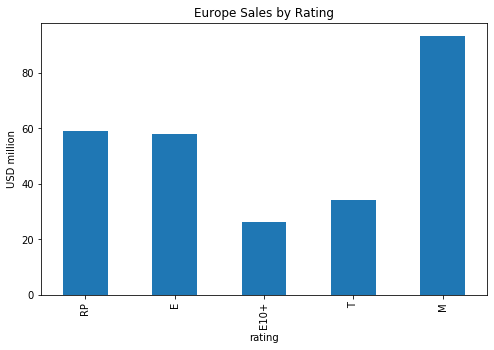

,eu_sales,%
rating,,
RP,58.950001,21.778484
E,58.060001,21.449684
E10+,26.160000,9.664549
T,34.070000,12.586819
M,93.440002,34.520470


In [45]:
sales_barplot(reg_rating('eu_sales')['eu_sales'], 'Europe Sales by Rating')
reg_rating('eu_sales')

Like with genres, the division of sales by ESRB rating in Europe is almost the same as in North America.

### Japan

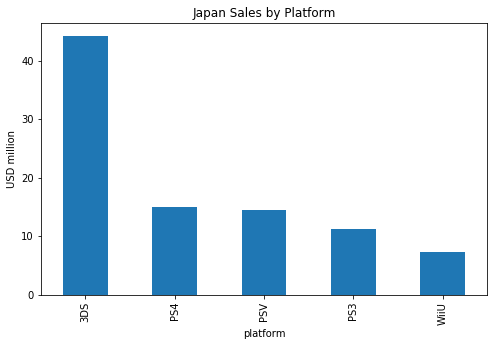

,jp_sales,%
platform,,
3DS,44.240002,47.523899
PS4,15.020000,16.134922
PSV,14.540000,15.619293
PS3,11.220000,12.052852
WiiU,7.310000,7.852615
PSP,0.360000,0.386723
XOne,0.320000,0.343753
X360,0.080000,0.085938
PC,0.000000,0.000000


In [46]:
sales_barplot(regional('jp_sales', 'platform')['jp_sales'].head(), 'Japan Sales by Platform')
regional('jp_sales', 'platform')

The Japanese are loyal to their local brands. Almost half of the market is occupied by Nintendo 3DS games. Next are the Sony platforms: Playstation 4, Playstation Vita and Playstation 3 (16%, 16%, 12%), followed by the Nintendo WiiU (8%). The Xbox One games didn't even make it to half of a single percent in Japan.

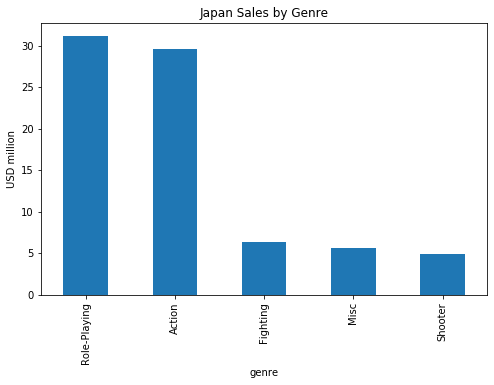

,jp_sales,%
genre,,
Role-Playing,31.16,33.472984
Action,29.58,31.775702
Fighting,6.37,6.842841
Misc,5.61,6.026426
Shooter,4.87,5.231496
Adventure,3.60,3.867225
Sports,3.26,3.501987
Platform,2.69,2.889677
Simulation,2.31,2.481470


In [47]:
sales_barplot(regional('jp_sales', 'genre')['jp_sales'].head(), 'Japan Sales by Genre')
regional('jp_sales', 'genre')

In Japan, RPGs take the lead, followed closely by action, both take up around a third of the market each. All other genres are in the single digits, including shooter (5.2%) and sports (3.5%), that have been among the most profitable genres in North America and Europe.

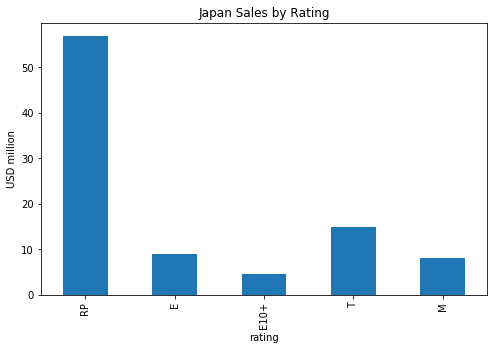

,jp_sales,%
rating,,
RP,56.900002,61.123646
E,8.940000,9.603608
E10+,4.460000,4.791062
T,14.780000,15.877107
M,8.010000,8.604576


In [48]:
sales_barplot(reg_rating('jp_sales')['jp_sales'], 'Japan Sales by Rating')
reg_rating('jp_sales')

Less than 40% of the sales in Japan are for games rated by the ESRB. It seems that games that sell well in Japan are not rated by ESRB very often. It would be better not do draw any conclusions with so many missing ratings.

## Testing Hypotheses
In this section we will T-test to following hypotheses:
- Average user ratings of the Xbox One and PC platforms are the same.
- Average user ratings for the Action and Sports genres are different.

$\alpha$ is set to 0.05. Like before, we only consider games released in 2014 or later. 

In [49]:
alpha = 0.05

### Xbox One VS PC

In [50]:
results = st.ttest_ind(
    df.query('platform == "XOne" and year_of_release > 2013')['user_score'].dropna(), 
    df.query('platform == "PC" and year_of_release > 2013')['user_score'].dropna(), 
    equal_var=False, # we know from section 3.3
)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('The average user score for Xbox One games and PC games differs.')
else:
    print('The null hypothesis cannot be rejected.')

p-value: 0.11601370428059007
The null hypothesis cannot be rejected.


This means that according to our sample only, we cannot reject the hypothesis that average user ratings of the Xbox One and PC platforms are the same.

### Action VS Sports

In [51]:
results = st.ttest_ind(
    df.query('genre == "Action" and year_of_release > 2013')['user_score'].dropna(), 
    df.query('genre == "Sports" and year_of_release > 2013')['user_score'].dropna(), 
    equal_var=False, # we know from section 3.4
)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('The average user score for action games and sports games differs.')
else:
    print('The null hypothesis cannot be rejected.')

p-value: 1.1825449415241103e-14
The average user score for action games and sports games differs.


This means that according to our sample only, average user ratings of the action and sports genres significantly differ.

## Conclusions
Entire dataset:

- Less than a quarter of the games in the dataset were released in the last 5 years
- The highest sales by any metric are in North America, followed by Europe, Japan, and lastly, 'Other'
- Need for Speed: Most Wanted appeared in no less than 12(!) platforms, more than any other game.
- The Playstation 2 is the platform with the most titles (2161 titles).
- The most common genre is action (3369 titles).
- The most common ESRB rating is E (everyone) (3990 titles).
- the number of games released per year increased since the early 90's, peaked at over 1400 in 2008 and 2009, and dropped to 500-700 in the last 5 years.
- The top 5 platforms of all time (by game sales) are Sony Playstation 2, Xbox 360, Sony Playstation 3, Nintendo Wii and Nintendo DS.
- Gaming platforms have a several years life cycle, where game sales rise and fall. The all-time top platforms are already at the end of their life cycles.

Games realeased in 2014 to 2016:
- Playstation 4 and Xbox One are entering 2017 with an upward trajectory, with the former doing significantly better than the latter.
- Most profit comes from a relatively small selection of very successful games. 
- Playstation 4 is the platform on which the average game is most profitable, followed by Xbox One and WiiU.
- Playstation 4 is the platform with most games published, followed by Xbox One and Nintendo 3DS.
- Critic scores for Playstation 4 are moderately correlated to sales, while user scores are not correlated at all.
- The same games make more money on Playstation 4 than on Xbox One.
- Shooter have been the most profitable genre per game by a large margin, followed by sports, while the most common was action.
- In North America most of the market is occupied by similar shares of Playstation 4 and Xbox One, while the European market is dominated by Playstation 4 and the Japanese market by Nintendo 3DS.
- North American and European audiences have similiar preferences for game genres: mainly shooter and action, secondly sports and RPG.
- The Japanese game market is dominated by the RPG and action genres, with little room for other genres.
- About a third of the market share in both North America and Europe is taken by M (mature) rated games.
- Less than 40% of the sales in Japan are for games rated by the ESRB.
- Average user ratings of the Xbox One and PC platforms do not significantly differ.
- Average user ratings of the action and sports genres significantly differ.